# Sentiment Analysis on Amazon Reviews

Now, we're going to take a deep dive into Natural Language Processing. One of the most common tasks in this domain is _sentiment analysis_, detecting whether the author had a _positive_ or _negative_ tone. We'll be applying this to a dataset of 34,000 Amazon product reviews.

We'll use the text of the reviews and titles as our _features_, and we'll have 3 possible labels:
- `positive` for all reviews of _4_ and _5_ stars
- `neutral` for all reviews of _3_ stars
- `negative` for all reviews of _2_ stars or below.

The dataset will be at `datasets/amazon_reviews.csv`. They have been adapted from a larger dataset available from [Kaggle](https://www.kaggle.com/datafiniti/consumer-reviews-of-amazon-products/version/3#).

In [589]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sklearn

# To create test/train splits
from sklearn.model_selection import train_test_split
# To help us go through different parameter configurations for
# each type of model.
from sklearn.model_selection import GridSearchCV
# To help us evaluate the model on each trial or "split"
from sklearn.model_selection import cross_val_score

# Naive Bayes
from sklearn.neighbors import KNeighborsClassifier
# Neural Networks
from sklearn.neural_network import MLPClassifier

from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import RandomForestClassifier
# Confusion matrix
from sklearn.metrics import confusion_matrix

In [590]:
# This is to stop the barrage of warning messages we'll get later
import warnings; warnings.simplefilter('ignore')

In [591]:
# Create a seed to use later.
seed = 42

In [592]:
# First import your dataset as usual
dataset = "datasets/amazon_dataset.csv"

df = pd.read_csv(dataset)

df.head()

,numHelpful,text,title,stars
0,2.0,I bought this tablet for my 4 year old daughte...,Ended up returning,1
1,0.0,"not good, hate it , never buy it again, sucks....",hate it,1
2,0.0,Freeze frequently... No way to trouble shoot o...,Very poor.,1
3,1.0,Does not let me connect with my library. Very ...,App options pathetic,5
4,0.0,I have only had this Amazon Fire Hd8 since Dec...,Quit charging,1


In [593]:
df.describe()

,numHelpful,stars
count,34129.000000,34622.000000
mean,0.630226,4.623332
std,13.216162,0.643558
min,0.000000,1.000000
25%,0.000000,4.000000
50%,0.000000,5.000000
75%,0.000000,5.000000
max,814.000000,5.000000


Look at the results from the table above. Does something seem off to you? If you know what [quartiles](https://www.mathsisfun.com/data/quartiles.html) are, then you should be seeing a pattern in the data from the table above.

Let's get some visualizations going to help us understand what's going on. Below, we're going to group our DataFrame rows by the column we care about, `stars`. __Note:__ we're going to get rid of this column soon since we care about `neutral` vs `negative` vs `positive`, not the actual number of stars someone gave.

In [594]:
# Let's get the counts of our columns after we group them by star count
df_star_counts = df.groupby("stars").count()
df_star_counts.head()

,numHelpful,text,title
stars,,,
1,140,147,147
2,231,241,241
3,1476,1500,1500
4,8668,8730,8730
5,23614,24004,24003


The text and title fields are effectively just counting the rows for us now. Ignoring the discrepancy in counts for text and title (this dataset is not perfect) we can see that the reviews for the products in this dataset are overwhelmingly 5's.

So, this dataset is not the best because it is biased towards 4's and 5's off the bat. Consequently, we should expect that after training, any of our estimators will spit out `positive` as the prediction almost all the time. Let's crunch some numbers below to see if we could come up with a better `classifier` giving the same prediction _100%_ of the time.

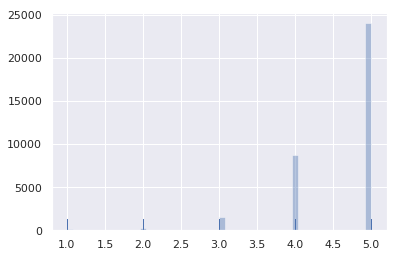

In [595]:
# First, let's just focus on the "text" column and get the values out.
# The list we get here will be the number of examples we have with 1-star,
# with 2-star, and so on
counts = df_star_counts["text"].values

# We'll make an array with the star counts
# So two 1's and four 2's would be: [1, 1, 2, 2, 2, 2]
stars = []
for idx, count in enumerate(counts):
    star_num = idx + 1
    stars += [star_num] * count 

# Here we can make a histogram of the stars. Looks like almost all the ratings are 4's or 5's
sns.distplot(stars, kde=False, rug=True)

In [596]:
# Let's count the total number of examples we have
n_samples = sum(counts)

# Now let's count only the "positive" examples, meaning 4's and 5's
n_positive = sum(counts[3:])

# TODO: Now, compute the ratio of "positive" examples to all examples
positive_ratio = n_positive / n_samples
print(positive_ratio)

0.9454681994107793


So check out the number above. It sounds absurd, but we could have a _classifier_ made that does nothing but give _positive_ for every example and we'd be hitting over 90% accuracy.

Ambitious though it may be, let's see if we can actually train a true classifier to improve our accuracy above what we got for _positive_ratio_.

Let's start by using a [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model) model.

In [597]:
# Step 1: We need to preprocess our data. For now, we'll only be using the text and stars fields
df = df[["text", "stars"]]
df.head()

,text,stars
0,I bought this tablet for my 4 year old daughte...,1
1,"not good, hate it , never buy it again, sucks....",1
2,Freeze frequently... No way to trouble shoot o...,1
3,Does not let me connect with my library. Very ...,5
4,I have only had this Amazon Fire Hd8 since Dec...,1


In [598]:
# Now, we'll build our counts of words.

# This built-in will help us out
from collections import Counter

def bag_of_words(text):
    """
    TODO: 
    1. Lowercase everything in the text
    2. Split up the text into words, and make a list called "words" that holds all the words
    3. Make sure all the words are lower-case and that you account for punctuation.
    Ex: "awesome!" is not one "word", it's really "awesome" and "!".
    4. Finally, return Counter(words), which will be a dictionary with counts of the occurence
    of each word
    """
    punctuation = [".", ",", "(", ")", "'", ":", ";", '"', "\\", "!", "?", "'"] # HINT: filter these out
    for punc in punctuation:
        text = text.replace(punc, "")
    lowercase = text.lower()
    words = lowercase.split(" ")
    
    return Counter(words)


In [599]:
# Now, pluck out the dataframe's "text" column values
text_vals = df["text"].values
text_vals[0]

'I bought this tablet for my 4 year old daughter. Too many advertisements. I would rather pay more and not have a single ad.'

In [600]:
# Apply the bag_of_words to the functions and store those in a list called bows.
bows = []
for text in text_vals:
    bow = bag_of_words(text)
    bows.append(bow)

In [601]:
# So, now we have the bag of words for ALL text in our dataset. Let's build a vocabulary out of this
# Each bow is a Counter object, so we want to keep the total occurences of words in the dataset

word_occurences = Counter()

for bow in bows:
    word_occurences.update(bow)


In [602]:
# Now, let's filter out the words that have at least 10 occurences
vocab = set()
removed_vocab = set()

for word, count in word_occurences.items():
    if word.lower() in ["you", "be", "a", "to", "me", "i", "the", "it", "was", "this", "has", "a", "my", "he", "she", "they", "we", "but", "so"]:
        removed_vocab.add(word)
    elif count >= 0:
        vocab.add(word)
    else:
        removed_vocab.add(word)

In [603]:
# Let's see which words we removed
print(len(removed_vocab))
removed_vocab

18


{'a',
 'be',
 'but',
 'has',
 'he',
 'i',
 'it',
 'me',
 'my',
 'she',
 'so',
 'the',
 'they',
 'this',
 'to',
 'was',
 'we',
 'you'}

In [604]:
# Now, let's see how many words we kept
print(len(vocab))

19356


In [605]:
# Now, we create a bag_of_words_using_vocab function that does the same thing as
# bag_of_words above except we remove any words that are not in the vocab set

def bag_of_words_using_vocab(text, vocabulary=vocab):
    bow = bag_of_words(text)
    words = list(bow.keys())
    for word in words:
        if word not in vocabulary:
            bow.pop(word)
    
    return bow

In [606]:
# Now, use bag_of_words_using_vocab to create new bows
better_bows = []

for text in text_vals:
    better_bow = bag_of_words_using_vocab(text, vocabulary=vocab)
    better_bows.append(better_bow)

In [607]:
# Let's take a look at what's left in the bag of words now
better_bows[0]

Counter({'bought': 1,
         'tablet': 1,
         'for': 1,
         '4': 1,
         'year': 1,
         'old': 1,
         'daughter': 1,
         'too': 1,
         'many': 1,
         'advertisements': 1,
         'would': 1,
         'rather': 1,
         'pay': 1,
         'more': 1,
         'and': 1,
         'not': 1,
         'have': 1,
         'single': 1,
         'ad': 1})

In [608]:
# Now, lets create vectors out of these new bags of words
from sklearn.feature_extraction import DictVectorizer

# We now have these as our X vectors
vectorizer = DictVectorizer()
X = vectorizer.fit_transform(better_bows)

# This is not a DataFrame, so we can't do X.head()
X

<34622x19356 sparse matrix of type '<class 'numpy.float64'>'
	with 701114 stored elements in Compressed Sparse Row format>

In [609]:
y_stars = df["stars"].values
# This is not a DataFrame, so we can't do y_stars.head()
y_stars

array([1, 1, 1, ..., 5, 5, 5])

In [610]:
y = []

for stars in y_stars:
    if stars >= 4:
        y.append("positive")
    elif stars == 3:
        y.append("neutral")
    else:
        y.append("negative")

# This is not a DataFrame, so we can't do y.head()
y

['negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',

In [611]:
# Step 3: Split into test, train
# We want 70% train, 30% test
train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=seed)

## Step 4: Train Estimators

Use these two algorithms:
- [Neural Network](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)
- [MultinomialNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

__DO NOT DO CROSS VALIDATION__

## Step 5: Evaluation

Evaluate how well we did using Confusion matrices and accuracies

## Step 6: Improve the Model

Try these approaches to improve your model:
- Try changing the minimum occurences we want to have to something else, see if results improve
- Try removing useless words. Call these words "stop-words" in a list and prune them out of the vocab.
  - Ex: "the", "me", "you", "a"
- Try a different model and see if your accuracy improves (you can use CV at this point)


In [612]:
rf_params = [
    {
        "max_depth": [100, 200, 500, 1000, 2000, 3000, 5000, None],
        "criterion": ["entropy", "gini"],
        "min_samples_split": [2, 3, 4, 5, 10],
    }
]

classifier = RandomForestClassifier(random_state=seed, max_depth=None, n_estimators=150, n_jobs=2)
#dt_experimenter = GridSearchCV(classifier, rf_params, cv=5)
#dt_experimenter.fit(train_X, train_y)

#print("Best parameter set found: ")
#print(dt_experimenter.best_params_)


classifier.fit(train_X, train_y)
train_acc = classifier.score(train_X, train_y)
test_acc = classifier.score(test_X, test_y)



print("Train:", train_acc)
print("Test:", test_acc)

Train: 0.9999587373633175
Test: 0.9490709540772119
